### Imports

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import NearMiss

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore", message="A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.")


### Variables

In [2]:

late_drop = [
    'ipTTLMeanBwd',
    'ipTTLMeanFwd',
    'dot1qPriority',
    'dot1qVlanId',
    'reverseTcpSequenceNumber',
    'tcpSequenceNumber',
    'minimumTTL',
    'maximumTTL',
    'ipTTL',
    'tcpUrgentPointer',
    'tcpWindowSize',
    'flowStartDate',
    'tcpSequenceNumberFwd'
]

DROP = [
    #'attackCategory',
    'day',
    'destinationIPAddress',
    'destinationMacAddress',
    'destinationTransportPort',
    #'dot1qPriority',
    #'dot1qVlanId',
    #'ethernetType',
    'flowEndMicroseconds',
    'flowEndMilliseconds',
    'flowEndDate',
    'flowEndNanoseconds',
    'flowEndSeconds',
    'flowId',
    'flowStartMicroseconds',
    'flowStartMilliseconds',
    'flowStartNanoseconds',
    'flowStartSeconds',
    'getipClassOfService',
    'sourceIPAddress',
    'sourceMacAddress',
    'sourceTransportPort'
    
]

DROP = DROP + late_drop


In [3]:
def numpy_to_file(file_name, my_array):
    np.save(file_name, my_array)

def file_to_numpy(file_name):
    return np.load(file_name)


# Saving the object
def pickle_an_object(obj, file_name):
    with open(file_name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)


# Loading the object
def unpickle_an_object(file_name):
    with open(file_name, 'rb') as f:
        loaded_object = pickle.load(f)
    return loaded_object


def convert_to_numeric(df, DROP=DROP):
    convert_columns = []
    processed_data = []
    df_aux = df.copy()

    # Iterate over each column in the dataframe
    #for column in df.columns:
    for column in set(df_aux.columns) - set(DROP):
        if df_aux[column].dtype in ['int64', 'float64']:  # Check if column is numeric
            # Copy the numeric column to the processed dataframe
            processed_data.append(column)
        else:
            if column == 'attackCategory':
                processed_data.append(column)
            # Check if all values in the column can be converted to numeric
            elif pd.to_numeric(df_aux[column], errors='coerce').notna().all():
                #processed_data.append(df[column].astype(float))
                df_aux[column] = df_aux[column].astype(float)
                processed_data.append(column)
            else:
                # Perform label encoding on non-numeric columns after converting them to string
                label_encoder = LabelEncoder()
                encoded_column = label_encoder.fit_transform(df_aux[column].astype(str))
                #processed_data.append(pd.Series(encoded_column, name=column))
                df_aux[column] = pd.Series(encoded_column, name=column)
                convert_columns.append(column)
                processed_data.append(column)

    # Concatenate all the series to create the DataFrame
    #processed_df = pd.concat(processed_data, axis=1)

    #return processed_df#, convert_columns
    return df_aux


def find_correlated_features(df, correlation_threshold=0.9, corr_method='spearman'):
    # Compute the correlation matrix using Spearman method
    df_ = df.drop('attackCategory', axis=1)
    #attackCategory = df['attackCategory']
    corr_matrix = df_.corr(method=corr_method).abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

    # Find index of feature columns with correlation greater than threshold
    #correlated_pairs = [(column, row) for column in upper.columns for row in upper.index if upper.loc[row, column] > correlation_threshold]
    correlated_pairs = [(column, row, upper.loc[row, column]) for column in upper.columns for row in upper.index if upper.loc[row, column] > correlation_threshold]

    # Convert the pairs to a DataFrame
    #correlated_pairs_df = pd.DataFrame(correlated_pairs, columns=['feature1', 'feature2'])
    correlated_pairs_df = pd.DataFrame(correlated_pairs, columns=['feature1', 'feature2', 'correlation'])

    # Find the redundant features
    redundant_features = {row for _, row, _ in correlated_pairs}

    return correlated_pairs_df, redundant_features



def min_max_normalization(df, DROP=DROP):
    # Create a sub-dataframe without the DROP columns
    to_DROP = DROP + ['attackCategory']
    df_to_normalize = df.drop(to_DROP, axis=1)
    
    # Create a scaler object
    scaler = MinMaxScaler()
    
    # Fit the scaler to the data to be normalized and transform it
    normalized_df = pd.DataFrame(scaler.fit_transform(df_to_normalize), 
                                 columns=df_to_normalize.columns, 
                                 index=df_to_normalize.index)
    
    # Concatenate normalized and non-normalized dataframes
    result_df = pd.concat([df[to_DROP], normalized_df], axis=1)
    result_df['label'] = df['label']
    
    return result_df #, scaler


def undersampling(df, target_col='label', method='random'):
    #X = df.drop(DROP + [target_col], axis=1)
    X = df.drop(target_col, axis=1)
    y = df[target_col]

    if method == 'tomeklinks':
        undersample = TomekLinks()
    elif method == 'random':
        undersample = RandomUnderSampler(random_state=42)
    elif method == 'nearmiss':
        undersample = NearMiss()
    else:
        raise ValueError("Invalid method. Expect 'tomeklinks', 'random', or 'nearmiss'.")
    X_res, y_res = undersample.fit_resample(X, y)

    df_res = pd.DataFrame(X_res, columns=X.columns).copy()
    df_res[target_col] = y_res
    return df_res


def attack_selection(df, attack):
    df_normal = df.loc[df['attackCategory']=='normal']
    df_attack = df.loc[df['attackCategory']==attack]
    return pd.concat([df_normal, df_attack], axis=0)


def get_feature_importance(X, y):
    clf = RandomForestClassifier(criterion='entropy')
    clf.fit(X, y)

    importances = clf.feature_importances_
    df_importance = pd.DataFrame(np.hstack((X.columns.to_numpy().reshape(-1, 1), importances.reshape(-1, 1))), columns=['Feature', 'Importance'])
    return df_importance.sort_values('Importance', ascending=False)


def pre_processing(path, is_attack=False):
    print('Loading the dataframe...')
    df_original = pd.read_csv(path)

    print('Replacing NaN values with 0...')
    df = df_original.fillna(0)

    print('Replacing inf values with 0...')
    df = df.replace([np.inf, -np.inf], 0)

    print('Creating binary label...')
    df['label'] = df['attackCategory'].apply(lambda x: False if x == 'normal' else True)

    if is_attack:
        df = df.loc[df['label']==1]

    #print('Dropping columns')
    #df = df.drop(DROP, axis=1)

    print('Converting non-numerical to numerical features...')
    df = convert_to_numeric(df)

    #print('Normalizing the scale to avoid the dominance of features with different scales...')
    #df = z_score_normalization(df)
    #df = min_max_normalization(df)

    print('Dropping duplicate instances')
    df = df.drop_duplicates(keep='first')

    # fixing unsw-nb15 label - removing with space and renaming an attack
    df['attackCategory'] = df['attackCategory'].apply(lambda x: x.replace(" ", ""))
    df['attackCategory'] = df['attackCategory'].apply(lambda x: x.replace("Backdoor", "Backdoors"))

    return df_original, df

#'../data'
def append_baseline_normal_traffic(train_df, val_df, test_df):
    """
    Processes the provided datasets by removing 'normal' traffic and then appends 'normal' traffic 
    from the baseline datasets. 

    Parameters:
    - train_df (DataFrame): Training data.
    - val_df (DataFrame): Validation data.
    - test_df (DataFrame): Test data.

    Returns:
    - tuple: Processed train_df, val_df, test_df with 'normal' traffic (represented by label 0) from the baseline datasets.
    """
    
    # Reading the baseline datasets
    df_bs_train = pd.read_csv('../datasets/unsw-nb15_30min_no_payload_train.csv.gz')
    df_bs_test = pd.read_csv('../datasets/unsw-nb15_30min_no_payload_test.csv.gz')
    df_bs_val = pd.read_csv('../datasets/unsw-nb15_30min_no_payload_val.csv.gz')

    # Dropping the 'normal' traffic (now represented by label 0) from the provided datasets and resetting the index
    train_df = train_df[train_df['label'] != 0].reset_index(drop=True)
    val_df = val_df[val_df['label'] != 0].reset_index(drop=True)
    test_df = test_df[test_df['label'] != 0].reset_index(drop=True)

    # Extracting 'normal' traffic (now represented by label 0) from the baseline datasets
    normal_train = df_bs_train[df_bs_train['label'] == 0]
    normal_val = df_bs_val[df_bs_val['label'] == 0]
    normal_test = df_bs_test[df_bs_test['label'] == 0]

    # Concat the 'normal' traffic from the baseline datasets to the processed datasets and resetting the index
    train_df = pd.concat([train_df, normal_train], ignore_index=True)
    val_df = pd.concat([val_df, normal_val], ignore_index=True)
    test_df = pd.concat([test_df, normal_test], ignore_index=True)

    return train_df, val_df, test_df


def prepare_dataset_old(dataset_path, output_name, save_redundant_features=True, manipulated_pcap=False, train_test_val_split=True, under_sampling=True, DROP=DROP, df=None):
    if not df:
        _, df = pre_processing(dataset_path)

    # fixing unsw-nb15 label - removing with space and renaming an attack
    df['attackCategory'] = df['attackCategory'].apply(lambda x: x.replace(" ", ""))
    df['attackCategory'] = df['attackCategory'].apply(lambda x: x.replace("Backdoor", "Backdoors"))
    df['attackCategory'] = df['attackCategory'].apply(lambda x: x.replace("Backdoorss", "Backdoors"))
    

    print('Dropping duplicate instances')
    df = df.drop_duplicates()

    #selected_attack = 'ddos-loit'
    #print('selecting {} attack for the dataset...' .format(selected_attack))
    #df = attack_selection(df, selected_attack)

    print('Dropping not important features')
    df = df.drop(DROP, axis=1)

    if under_sampling:
        method_udersampling = 'random' #'tomeklinks', 'random', or 'nearmiss'
        print('Undersampling using {} method...' .format(method_udersampling))
        df = undersampling(df, method=method_udersampling)

    if save_redundant_features:
        print('Finding correlated features...')
        correlated_pairs_df, redundant_features = find_correlated_features(df, correlation_threshold=0.9)
        # Preparing to save train and test split with valid features
        pickle_an_object(obj=redundant_features, file_name='../datasets/' + output_name + '_redundant_features')

    if train_test_val_split:
        # Split dataset into train/val/test 0.4/0.3/0.3
        temp_df, test_df = train_test_split(df, test_size=3/10, random_state=42)
        train_df, val_df = train_test_split(temp_df, test_size=3/7, random_state=42)

        if manipulated_pcap:
            train_df, val_df, test_df = append_baseline_normal_traffic(train_df, val_df, test_df)


        train_df.to_csv('../datasets/' + output_name + '_train.csv.gz', index=False, compression='gzip')
        val_df.to_csv('../datasets/' + output_name + '_val.csv.gz', index=False, compression='gzip')
        test_df.to_csv('../datasets/' + output_name + '_test.csv.gz', index=False, compression='gzip')
    else:
        df.to_csv('../datasets/' + output_name + '.csv.gz', index=False, compression='gzip')

    #data = {
    #    'df_original': df_original,
    #    'df': df,
    #    'correlated_pairs_df': correlated_pairs_df,
    #    'redundant_features': redundant_features
    #}

    #print('You can use the following keys: {}' .format(data.keys()))
    #return data

def prepare_dataset(dataset_path, output_name, DROP=DROP, df=None):
    if df is None:
        _, df = pre_processing(dataset_path)

    #selected_attack = 'ddos-loit'
    #print('selecting {} attack for the dataset...' .format(selected_attack))
    #df = attack_selection(df, selected_attack)

    print('Dropping not important features')
    df = df.drop(DROP, axis=1)

    df.to_csv('../datasets/' + output_name + '.csv.gz', index=False, compression='gzip')


def prepare_dataset_unsb_nb15(dataset_path):
    days = ['day_22','day_17']
    _, df = pre_processing(dataset_path)
    split_name = None

    for day in days:
        if day == 'day_22':
            split_name = 'train_' + day
        elif day == 'day_17':
            split_name = 'test_' + day

        output_name = 'unsw-nb15_30min_' + split_name
        df_selected_day = df.loc[df['day']==day]

        prepare_dataset(
            dataset_path=None,
            output_name=output_name,
            DROP=DROP,
            df=df_selected_day
            )

def prepare_attacks_unsb_nb15(attack, factor):
    if attack == 'volume':
        attack_name = 'percent_payload'
    elif attack == 'time':
        attack_name = 'x_slow'
    elif attack == 'time_volume':
        attack_name = '_time_volume'
    else:
        raise Exception('Wrong attack!')

    dataset_path = '../../UNSW-NB15/go-flows/csv_files/csv_' + str(factor) + attack_name + '/unsw-nb15-full-with-label.csv'
    _, df = pre_processing(dataset_path, is_attack=True)
    
    split_name = None
    days = ['day_22','day_17']

    for day in days:
        split_name = str(factor) + attack_name + '_' + day

        output_name = 'realistic_attacks/unsw-nb15_30min_' + split_name
        df_selected_day = df.loc[df['day']==day]

        prepare_dataset(
            dataset_path=None,
            output_name=output_name,
            DROP=DROP,
            df=df_selected_day
            )





path_ids2017 = '../../CIC-IDS2017/go-flows/csv_file/30m/cic-ids2017_30m_labeled.csv'
path_nb15 = '../../UNSW-NB15/go-flows/csv/30m/unsw-nb15-full-with-label.csv'
path_bot_iot = '../../Bot-IoT/Bot-IoT_Dataset/go-flows/bot_iot_balanced.csv'

In [ ]:
# load csv
df = pd.read_csv(path_nb15)

In [5]:

time_attack = ["0.2", "0.5", "0.7", "1.1", "1.2", "1.3", "2", "3", "4", "50", "100"]
#volume_attack = ["10", "20", "30", "40", "50", "60", "100", "-10", "-20", "-30", "-40", "-50", "-60", "-90"]
volume_attack= ["60", "70", "80", "90"]
time_volume_attack = ["-90", "-80", "-70", "-60", "-50", "-40", "-30", "-20", "-10", "10", "20", "30", "40", "50", "60", "70", "80", "90"]                
time_volume_attack = ["100"]
for factor in time_volume_attack:
        prepare_attacks_unsb_nb15(factor=factor, attack='time_volume')

Loading the dataframe...
Replacing NaN values with 0...
Replacing inf values with 0...
Creating binary label...
Converting non-numerical to numerical features...
Dropping duplicate instances
Dropping not important features
Dropping not important features


In [6]:
time_attack = ["-90", "-80", "-70", "-60", "-50", "-40", "-30", "-20", "-10", "10", "20", "30", "40", "50", "60", "70", "80", "90", "100"]
for factor in time_attack:
        prepare_attacks_unsb_nb15(factor=factor, attack='time')

Loading the dataframe...


Replacing NaN values with 0...
Replacing inf values with 0...
Creating binary label...
Converting non-numerical to numerical features...
Dropping duplicate instances
Dropping not important features
Dropping not important features
Loading the dataframe...
Replacing NaN values with 0...
Replacing inf values with 0...
Creating binary label...
Converting non-numerical to numerical features...
Dropping duplicate instances
Dropping not important features
Dropping not important features
Loading the dataframe...
Replacing NaN values with 0...
Replacing inf values with 0...
Creating binary label...
Converting non-numerical to numerical features...
Dropping duplicate instances
Dropping not important features
Dropping not important features
Loading the dataframe...
Replacing NaN values with 0...
Replacing inf values with 0...
Creating binary label...
Converting non-numerical to numerical features...
Dropping duplicate instances
Dropping not important features
Dropping not important features
Loadi

In [7]:
volume_attack = ["-80", "-70"]
for factor in volume_attack:
        prepare_attacks_unsb_nb15(factor=factor, attack='volume')

Loading the dataframe...
Replacing NaN values with 0...
Replacing inf values with 0...
Creating binary label...
Converting non-numerical to numerical features...
Dropping duplicate instances
Dropping not important features
Dropping not important features
Loading the dataframe...
Replacing NaN values with 0...
Replacing inf values with 0...
Creating binary label...
Converting non-numerical to numerical features...
Dropping duplicate instances
Dropping not important features
Dropping not important features


In [4]:
import time

# Sleep for 30 minutes
#time.sleep(30 * 60)
#factors=("1" "1.1" "1.2" "1.3" "2" "3" "4" "1.4" "1.5" "1.6" "1.7" "1.8" "1.9" "5" "6" "7" "8" "9" "10")
#files = [1]
#files = [1.1]
#files = [1.2, 1.3]
#files = [2, 3, 4]
files = [21, 22, 23, 24, 25, 26, 27,28, 29]

#for i in range(8, 11):
for i in files:
    #dataset_path = '../../UNSW-NB15/go-flows/csv_files/csv_' + str(i) + 'x_slow/unsw-nb15-full-with-label.csv'
    #output_name = 'unsw-nb15_30min_' + str(i) + 'x_slow'
    dataset_path = '../../UNSW-NB15/go-flows/csv_files/csv_' + str(i) + 'percent_payload/unsw-nb15-full-with-label.csv'
    output_name = 'unsw-nb15_30min_' + str(i) + 'percent_payload'
    if i != 1:
        print('working on {} i' .format(i))
        prepare_dataset(dataset_path=dataset_path, output_name=output_name, save_redundant_features=False, manipulated_pcap=True)
    else:
        print('working on {} e' .format(i))
        prepare_dataset(dataset_path=dataset_path, output_name=output_name, save_redundant_features=False, manipulated_pcap=False)

working on 21 i
Loading the dataframe...
Replacing NaN values with 0...
Replacing inf values with 0...
Creating binary label...
Converting non-numerical to numerical features...
Dropping duplicate instances
Undersampling using random method...
working on 22 i
Loading the dataframe...
Replacing NaN values with 0...
Replacing inf values with 0...
Creating binary label...
Converting non-numerical to numerical features...
Dropping duplicate instances
Undersampling using random method...
working on 23 i
Loading the dataframe...
Replacing NaN values with 0...
Replacing inf values with 0...
Creating binary label...
Converting non-numerical to numerical features...
Dropping duplicate instances
Undersampling using random method...
working on 24 i
Loading the dataframe...
Replacing NaN values with 0...
Replacing inf values with 0...
Creating binary label...
Converting non-numerical to numerical features...
Dropping duplicate instances
Undersampling using random method...
working on 25 i
Loading 

In [7]:
day = 'day-17'
dataset_path = '../../UNSW-NB15/go-flows/csv/30m/unsw-nb15-' + day + '-with-label.csv.gz'
output_name = 'unsw-nb15_30min_' + day

prepare_dataset(dataset_path=dataset_path, output_name=output_name, save_redundant_features=False, manipulated_pcap=False, train_test_val_split=False,under_sampling=False)

Loading the dataframe...
Replacing NaN values with 0...
Replacing inf values with 0...
Creating binary label...
Converting non-numerical to numerical features...
Dropping duplicate instances
Dropping not important features


In [7]:
import time

# Sleep for 30 minutes
#time.sleep(30 * 60)
#factors=("1" "1.1" "1.2" "1.3" "2" "3" "4" "1.4" "1.5" "1.6" "1.7" "1.8" "1.9" "5" "6" "7" "8" "9" "10")
#files = [1]
#files = [1.1]
#files = [1.2, 1.3]
#files = [2, 3, 4]
files = [0.2, 0.5, 0.7, 1.1, 1.2, 1.3, 2, 3, 4, 50]

#for i in range(8, 11):
for i in files:
    dataset_path = '../../UNSW-NB15/go-flows/csv_files/csv_' + str(i) + 'x_slow/unsw-nb15-full-with-label.csv'
    output_name = 'unsw-nb15_30min_' + str(i) + 'x_slow'
    #dataset_path = '../../UNSW-NB15/go-flows/csv_files/csv_' + str(i) + 'percent_payload/unsw-nb15-full-with-label.csv'
    #output_name = 'unsw-nb15_30min_' + str(i) + 'percent_payload'
    if i != 1:
        print('working on {} i' .format(i))
        prepare_dataset(dataset_path=dataset_path, output_name=output_name, save_redundant_features=False, manipulated_pcap=True)
    else:
        print('working on {} e' .format(i))
        prepare_dataset(dataset_path=dataset_path, output_name=output_name, save_redundant_features=False, manipulated_pcap=False)

working on 0.2 i
Loading the dataframe...
Replacing NaN values with 0...
Replacing inf values with 0...
Creating binary label...
Converting non-numerical to numerical features...
Dropping duplicate instances
Undersampling using random method...
working on 0.5 i
Loading the dataframe...
Replacing NaN values with 0...
Replacing inf values with 0...
Creating binary label...
Converting non-numerical to numerical features...
Dropping duplicate instances
Undersampling using random method...
working on 0.7 i
Loading the dataframe...
Replacing NaN values with 0...
Replacing inf values with 0...
Creating binary label...
Converting non-numerical to numerical features...
Dropping duplicate instances
Undersampling using random method...
working on 1.1 i
Loading the dataframe...
Replacing NaN values with 0...
Replacing inf values with 0...
Creating binary label...
Converting non-numerical to numerical features...
Dropping duplicate instances
Undersampling using random method...
working on 1.2 i
Loa

In [5]:
print('CIC-IDS2017...')
prepare_dataset(dataset_path=path_ids2017, output_name='cic-ids2017.csv')

CIC-IDS2017...
Loading the dataframe...
Replacing NaN values with 0...
Replacing inf values with 0...
Creating binary label...
Converting non-numerical to numerical features...
Normalizing the scale to avoid the dominance of features with different scales...
Undersampling using random method...
Finding correlated features...


In [6]:
print('\n\nBot-IoT...')
prepare_dataset(dataset_path=path_bot_iot, output_name='bot-iot.csv')



Bot-IoT...
Loading the dataframe...
Replacing NaN values with 0...
Replacing inf values with 0...
Creating binary label...
Converting non-numerical to numerical features...
Normalizing the scale to avoid the dominance of features with different scales...
Undersampling using random method...
Finding correlated features...


In [7]:
import pandas as pd
from sklearn.metrics import f1_score

train = pd.read_csv('../datasets/train_bot-iot.csv')
test = pd.read_csv('../datasets/test_bot-iot.csv')

X_train = train.drop(['attackCategory', 'label'], axis=1).to_numpy()
y_train = train['label'].to_numpy()

X_test = test.drop(['attackCategory', 'label'], axis=1).to_numpy()
y_test = test['label'].to_numpy()

In [11]:
import pandas as pd
from EspPipeML import esp_utilities

def comparing_datasets(split='test'):
    df_bs = pd.read_csv('../datasets/unsw-nb15_30min_1x_slow_' + split + '.csv.gz')
    df_payload = pd.read_csv('../datasets/unsw-nb15_30min_no_payload_' + split + '.csv.gz')
    rank = esp_utilities.rank_columns_by_ks_statistic(df_bs[df_payload.columns], df_payload)

    print('Comparing {} dataset' .format(split))

    print('Base line dataset: ')
    esp_utilities.plot_boxplots(df_bs[rank])

    print('No payload dataset: ')
    esp_utilities.plot_boxplots(df_payload[rank])

Comparing test dataset
Base line dataset: 


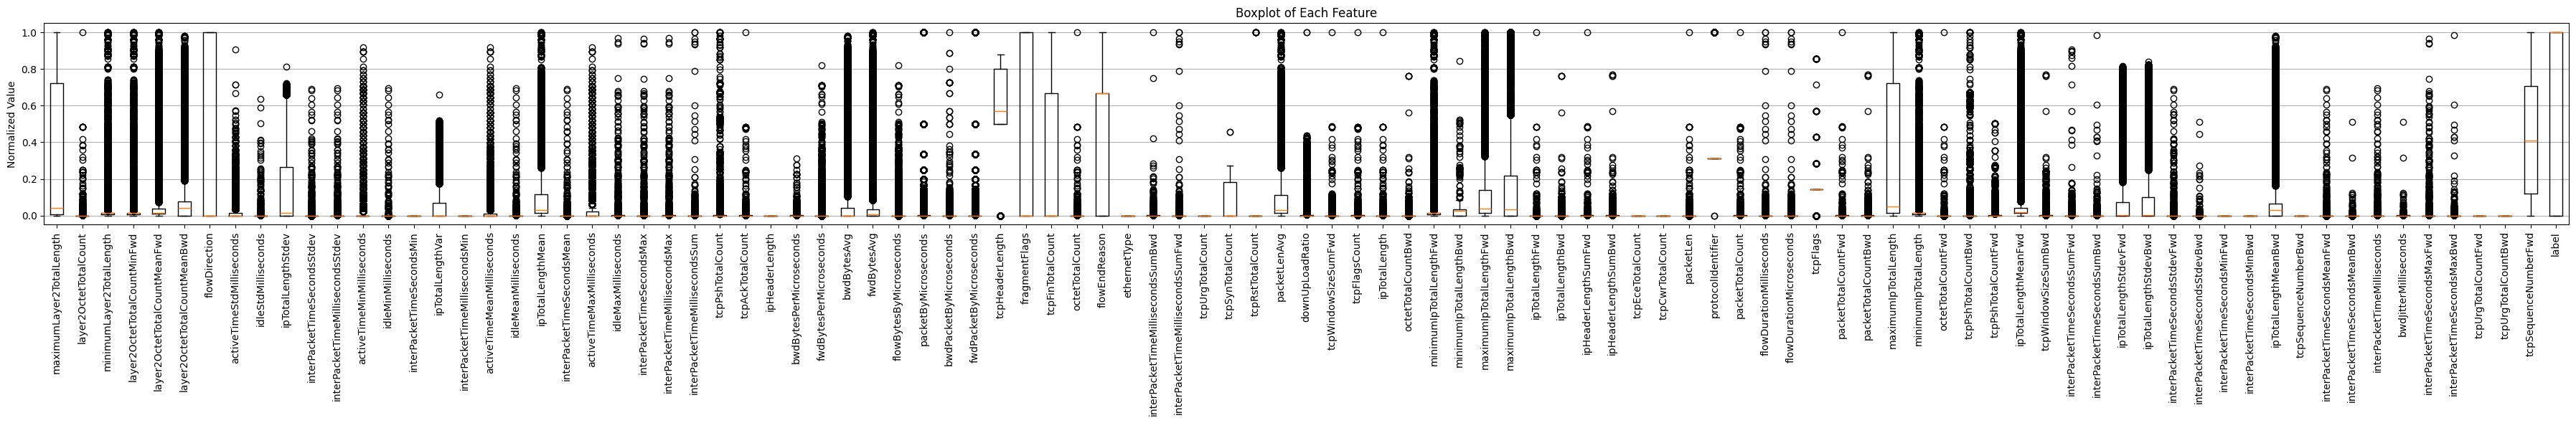

No payload dataset: 


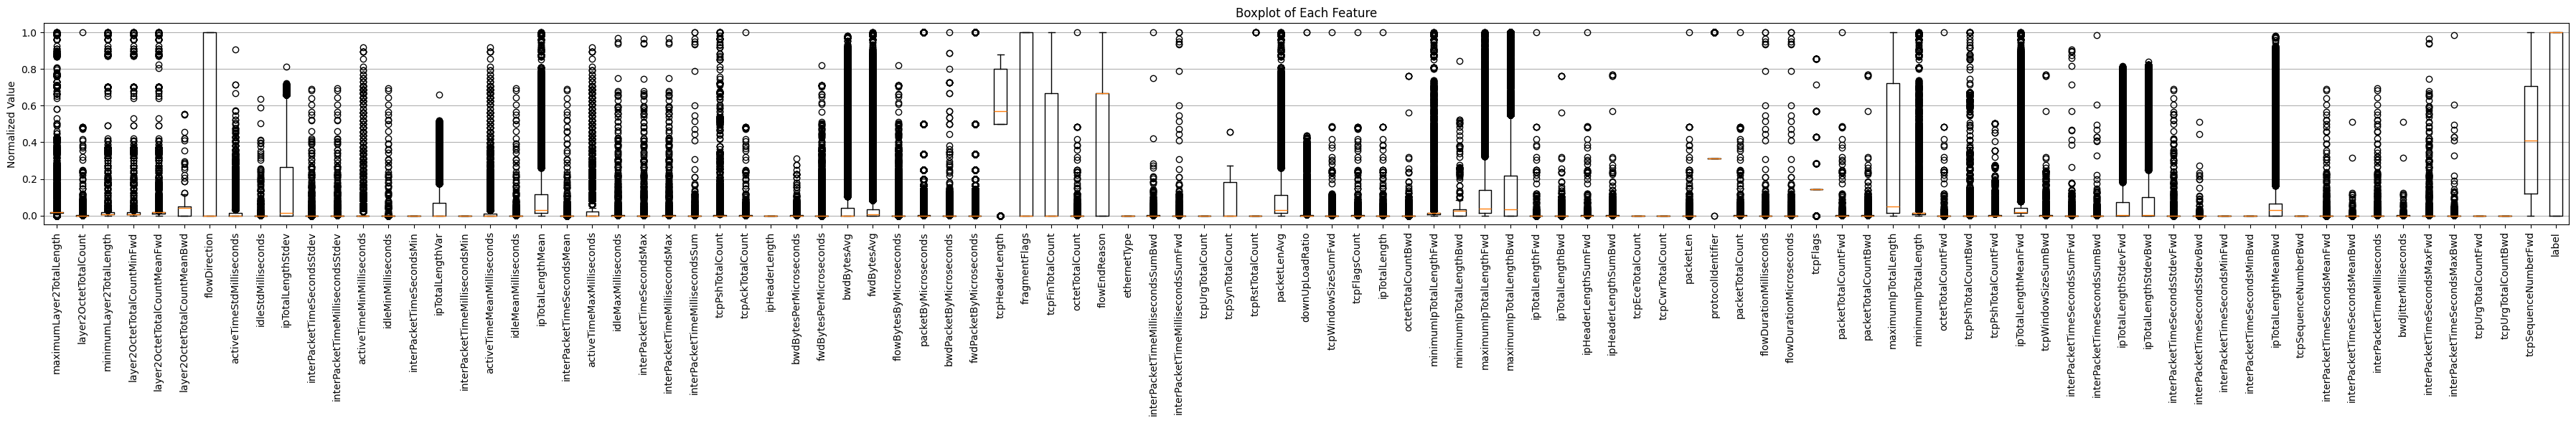

In [12]:
comparing_datasets(split='test')

Comparing val dataset
Base line dataset: 


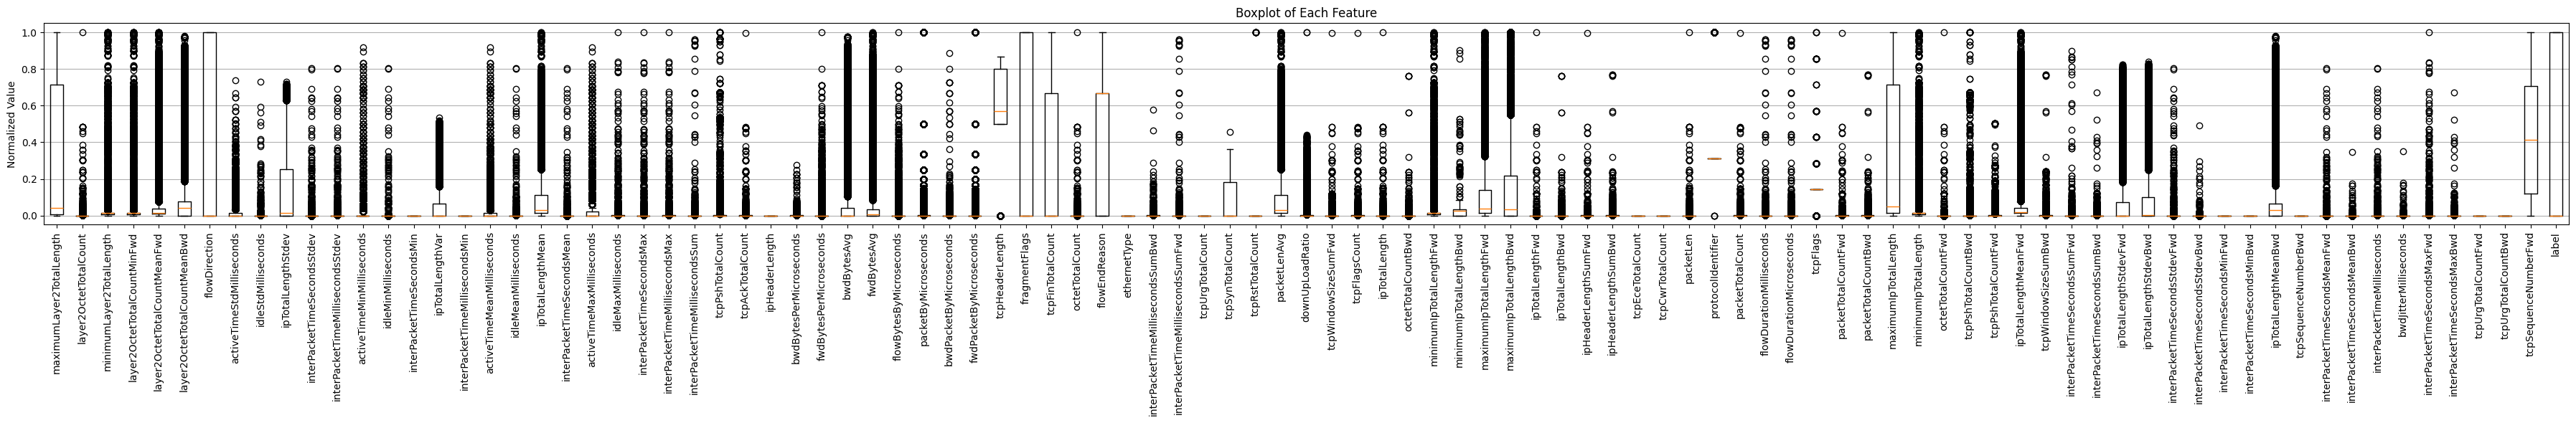

No payload dataset: 


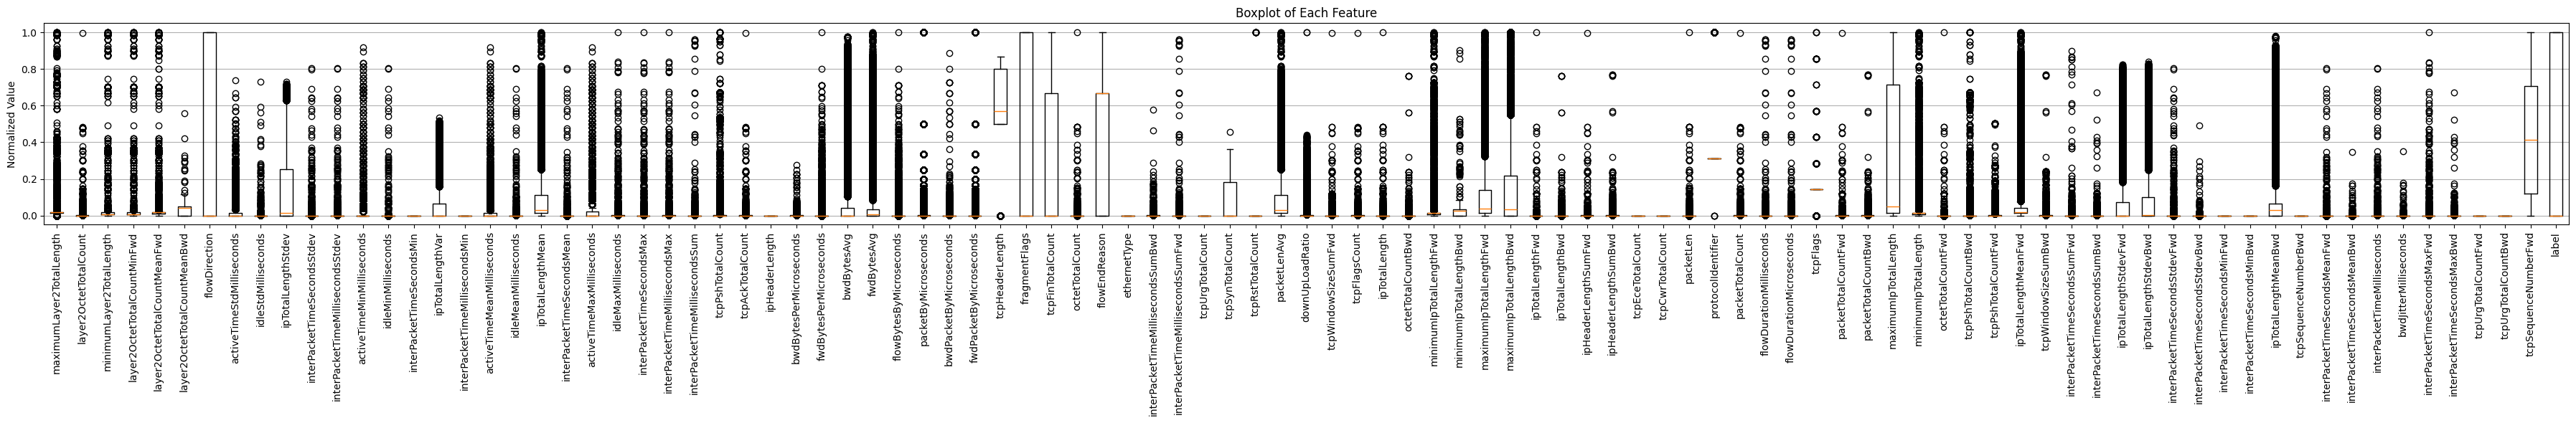

In [13]:
comparing_datasets(split='val')

Comparing train dataset
Base line dataset: 


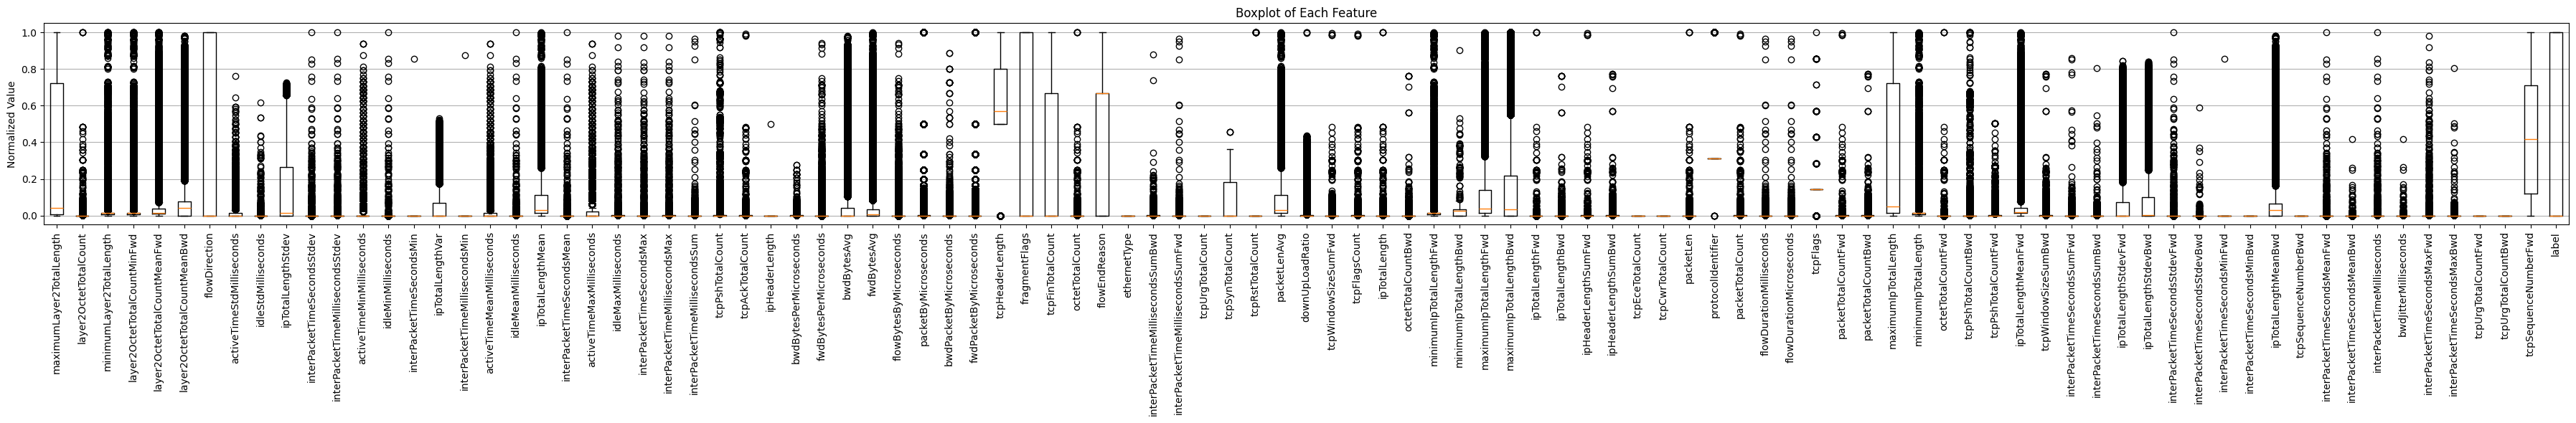

No payload dataset: 


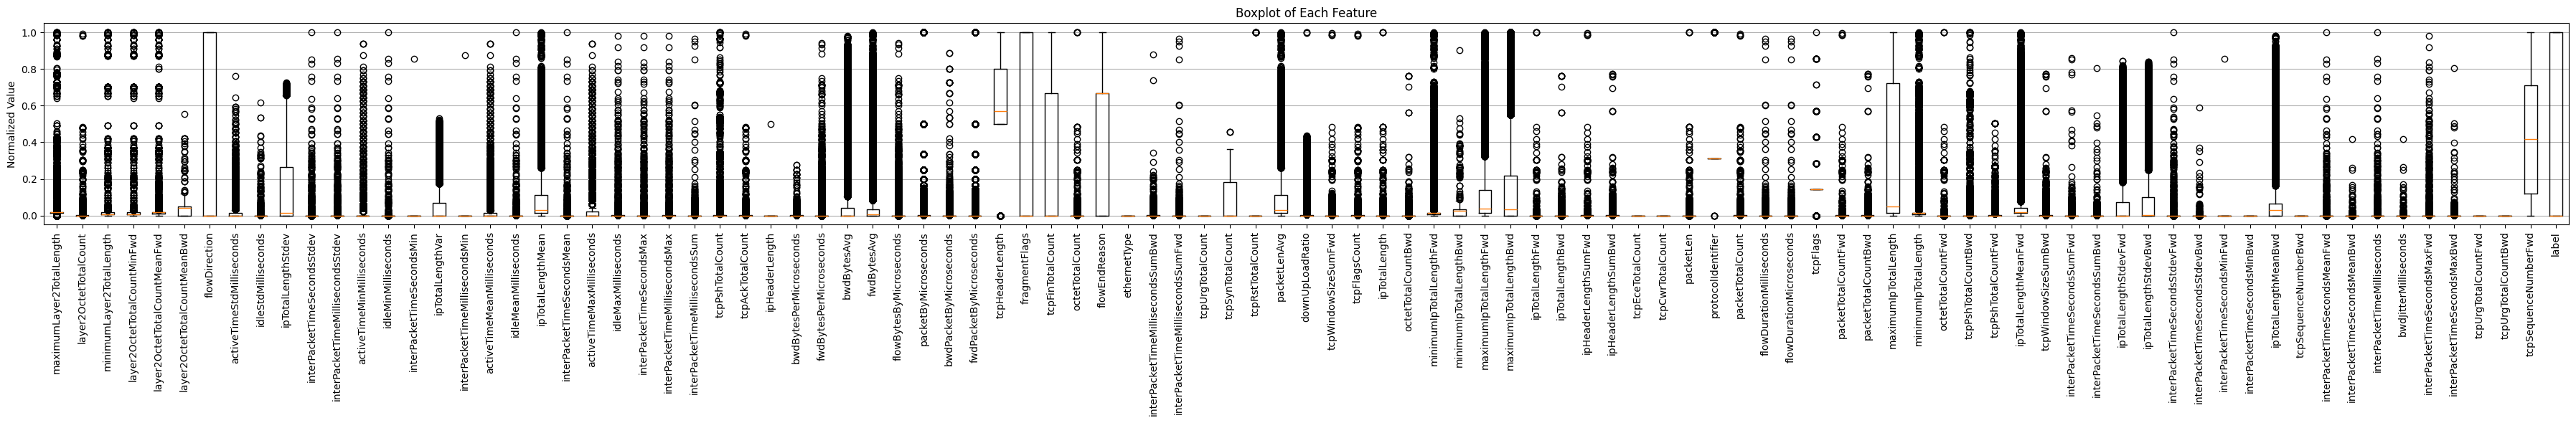

In [14]:
comparing_datasets(split='train')